# Sentiment Analysis

This is a project that can predict whether a person's comment is positive or not. A basic Recurrent Neural Network (RNN) is going to be used for this job. During the project, we will use the IMDB dataset, which includes user comments and labels. You can get the dataset from Keras easily, like below. The main purpose of this project is to classify the comments for a specific issue. For instance, a business might introduce a product and then gather and classify customers' opinions to develop it using this project.

## Context
* Importing the Required Libraries and Dataset
* Exploratory Data Analysis (EDA)
* Preprocessing the Dataset
* Contructing the RNN Model
* Training the RNN Model
* Results

Now, let's start with the first part importing the libraries.

## Importing the Required Libraries and Dataset

In [1]:
# import the required libraries

# to do math
import numpy as np
from scipy import stats

# to visualize
import matplotlib.pyplot as plt
import seaborn as sns

# dataset
from keras.datasets import imdb

# to create the model
from keras.utils import pad_sequences 
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Activation

We imported the libraries that we will use during the project. Now, we are ready to import the dataset, and continue with the part of EDA.

In [2]:
# import the dataset

(xTrain, yTrain), (xTest, yTest) = imdb.load_data(path = "imdb.npz", 
                                                  num_words = None, 
                                                  skip_top = 0, 
                                                  maxlen = None, 
                                                  seed = 113, 
                                                  start_char = 1, 
                                                  oov_char = 2,
                                                  index_from = 3)

print("xTrain Size:", xTrain.shape)
print("xTest Size:", xTest.shape)
print("yTrain Size:", yTrain.shape)
print("yTest Size:", yTest.shape)

xTrain Size: (25000,)
xTest Size: (25000,)
yTrain Size: (25000,)
yTest Size: (25000,)


## Exploratory Data Analysis (EDA)

In this part, we will examine our data in detail. First, let's look at the labels and their counts.

yTrain Distribution: {0: 12500, 1: 12500}
yTest Distribution: {0: 12500, 1: 12500}


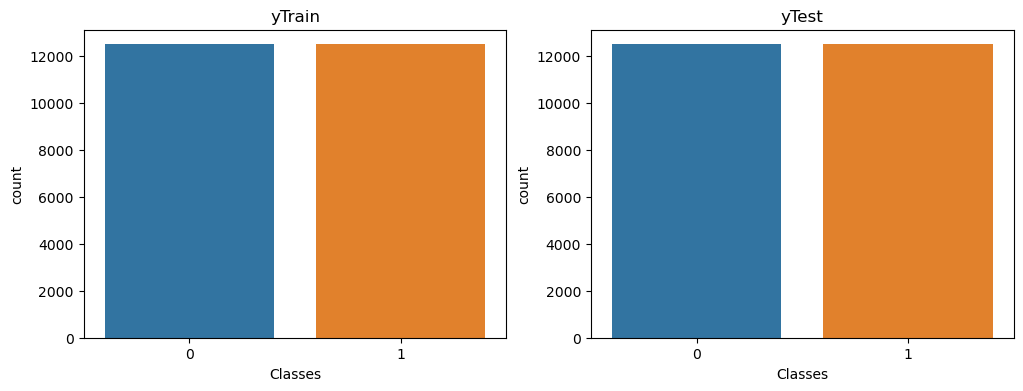

In [3]:
# disribution of the y values

unique, count = np.unique(yTrain, return_counts = True)
print("yTrain Distribution:", dict(zip(unique, count)))

unique, count = np.unique(yTest, return_counts = True)
print("yTest Distribution:", dict(zip(unique, count)))

fig, ax = plt.subplots(1, 2, figsize = (12, 4))

sns.countplot(x = yTrain, ax = ax[0])
ax[0].set_title("yTrain")
ax[0].set_xlabel("Classes")

sns.countplot(x = yTest, ax = ax[1])
ax[1].set_title("yTest")
ax[1].set_xlabel("Classes")

plt.show()

As you see above, the labels are totally balanced. Now, let's look at the distribution of data.

Train Mean: 238.71364
Train Median: 178.0
Train Mode: ModeResult(mode=array([132]), count=array([196]))
Test Mean: 230.8042
Test Median: 174.0
Test Mode: ModeResult(mode=array([125]), count=array([184]))


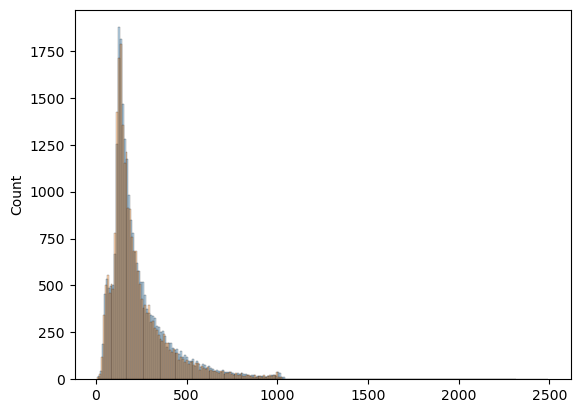

In [4]:
# disribution of the x values

reviewLenTrain = list()
reviewLenTest = list()

for i1, i2 in zip(xTrain, xTest):
    reviewLenTrain.append(len(i1))
    reviewLenTest.append(len(i2))
    
print("Train Mean:", np.mean(reviewLenTrain))
print("Train Median:", np.median(reviewLenTrain))
print("Train Mode:", stats.mode(reviewLenTrain))

print("Test Mean:", np.mean(reviewLenTest))
print("Test Median:", np.median(reviewLenTest))
print("Test Mode:", stats.mode(reviewLenTest))
    
plt.figure()    

sns.histplot(reviewLenTrain, alpha = 0.3)
sns.histplot(reviewLenTest, alpha = 0.3)

plt.show()

When looking at the graph above, the distribution of the length of the comments is quite wide. However, to train our model, we need to fix the size of the comments. It will be reasonable to select the mode value for this task. Also, we need increase our train data because the test data is quite much when comparing with the train data. We will do those in the preprocessing part. Now, let's create a function that converts the numbers in the xTrain to real texts to understand the dataset more deeply.

In [5]:
# define what_it_say

def what_it_say(index):
    reverseIndex = dict([(value, key) for (key, value) in imdb.get_word_index().items()])
    decodeReview = " ".join([reverseIndex.get(i - 3, "!") for i in xTrain[index]])
    print("Comment:\n--------\n" + decodeReview + "\n--------")
    print("Label:", yTrain[index])

what_it_say(24)

Comment:
--------
! the original demille movie was made in 1938 with frederic march a very good film indeed hollywood's love of remakes brings us a fairly interesting movie starring yul brynner he of course was brilliant as he almost always seemed to be in all of his movies charlton heston as andrew jackson was a stroke of genius however the movie did tend to get a little long in places it does not move at the pace of the 1938 version still it is a fun movie that should be seen at least once
--------
Label: 1


We did everything for the EDA part. Now, we can continue with the preprocessing part.

## Preprocessing the Dataset

In this part, we will preprocess the data for the model. First, we will reduce the length of data because there are a lot of outliers in the data, and we need to get rid of them. Then, we need to skip some common words such as the, a, an, of, and so on because these words are not informative for the model. Those processes will increase our accuracy.

In [6]:
# reduce the length of data

numOfWords = 15000

(xTrain, yTrain), (xTest, yTest) = imdb.load_data(num_words = numOfWords, 
                                                  skip_top = 5)

Now, as we mentioned above, we need to fix the length of comments with the mode number, which is approximately 130.

In [7]:
# fix the inputs

maxLen = 130

xTrain = pad_sequences(xTrain, maxlen = maxLen)
xTest = pad_sequences(xTest, maxlen = maxLen)

what_it_say(5)

Comment:
--------
! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! begins better than it ends funny that ! russian submarine crew ! all other actors it's like those scenes where documentary shots br br spoiler part ! message ! was contrary to ! whole story it just does not ! br br
--------
Label: 0


As you see, comments whose lengths are less than 130 filled with the charachter of "!". Now, we can continue with creating the RNN model.

## Contructing the RNN Model

Now, we will start to construct our model.

In [8]:
# construct the RNN model

rnn = Sequential()
rnn._name = "sentiment_analysis"

rnn.add(Embedding(numOfWords, 32, input_length = maxLen))
rnn.add(SimpleRNN(16, 
                  input_shape = (numOfWords, maxLen), 
                  return_sequences = False, 
                  activation = "relu"))
rnn.add(Dense(1))
rnn.add(Activation("sigmoid"))

print(rnn.summary())

Model: "sentiment_analysis"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 32)           480000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 480,801
Trainable params: 480,801
Non-trainable params: 0
_________________________________________________________________
None


Now, let's define the optimizer and loss function.

In [9]:
# compile the model

rnn.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])

Now, we are ready to train the model. Let's continue with the next part.

## Training the RNN Model

In [10]:
# train the model

numOfEpochs = 6
batchSize = 256

history = rnn.fit(xTrain, yTrain, 
                  validation_data = (xTest, yTest), 
                  epochs = numOfEpochs, 
                  batch_size = batchSize, 
                  verbose = 1)

Epoch 1/6
98/98 [==============================] - 6s 42ms/step - loss: 0.6596 - accuracy: 0.6115 - val_loss: 0.5669 - val_accuracy: 0.7584
Epoch 2/6
98/98 [==============================] - 4s 38ms/step - loss: 0.5004 - accuracy: 0.8055 - val_loss: 0.4653 - val_accuracy: 0.8199
Epoch 3/6
98/98 [==============================] - 4s 39ms/step - loss: 0.3825 - accuracy: 0.8582 - val_loss: 0.3840 - val_accuracy: 0.8401
Epoch 4/6
98/98 [==============================] - 4s 41ms/step - loss: 0.2950 - accuracy: 0.8833 - val_loss: 0.3561 - val_accuracy: 0.8452
Epoch 5/6
98/98 [==============================] - 4s 39ms/step - loss: 0.2394 - accuracy: 0.9056 - val_loss: 0.3445 - val_accuracy: 0.8570
Epoch 6/6
98/98 [==============================] - 4s 41ms/step - loss: 0.1972 - accuracy: 0.9243 - val_loss: 0.3348 - val_accuracy: 0.8596


The training process is done, so we can continue with the results part.

## Results

In [11]:
# evaluate the results

score = rnn.evaluate(xTest, yTest)
print("Accuracy: %{:.3f}".format(score[1] * 100))

782/782 [==============================] - 4s 5ms/step - loss: 0.3348 - accuracy: 0.8596
Accuracy: %85.960


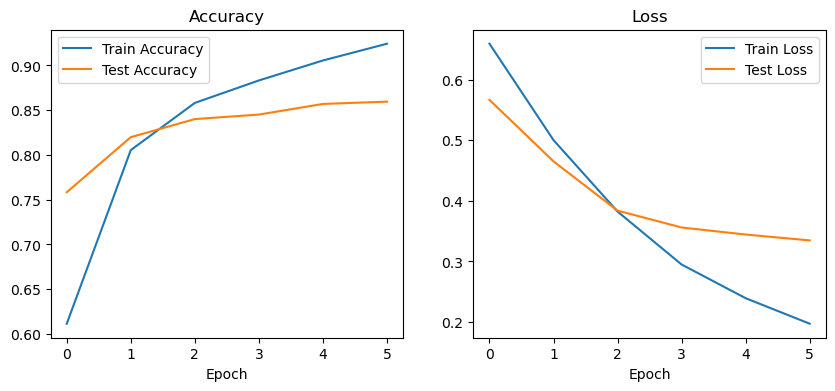

In [12]:
# visualize the results

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(history.history["accuracy"], label = "Train Accuracy")
ax[0].plot(history.history["val_accuracy"], label = "Test Accuracy")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(history.history["loss"], label = "Train Loss")
ax[1].plot(history.history["val_loss"], label = "Test Loss")
ax[1].set_title("Loss")
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.show()

In this project, we tried to construct a basic RNN model for sentiment analysis. When looking at the results, we have a slight overfitting problem, but you can handle it by tuning the parameters, adding more layers to the model, and adding some data to the training data from the test data.